# Supplemental Information E - Bayesian Parameter Estimation

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [29]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Defining the problem

In this notebook we will develop the Bayesian parameter estimation of the missing MWC parameters using Markov-Chain Monte Carlo sampling. Recall that the fold-change in gene expression for the simple repression architecture is given by
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{K_A} \right)^2}{\left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{K_I} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1},
\tag{1}
$$
where $\beta \equiv \frac{1}{k_BT}, $ $c$ is the inducer concentration, $K_A$ and $K_I$ are the dissociation constants of the inducer binding to the repressor in the active and inactive state, respectively, $\Delta\varepsilon_{AI}$ is the energy difference between the active and inactive state conformations, $R$ is the repressor copy number, $N_{NS}$ is the number of non-specific binding sites where the repressor can bind, and $\Delta\varepsilon_{RA}$ is the binding energy of the repressor to the DNA.

The objective of the parameter estimation is to compute the probability distribution of the parameters $K_A$, $K_I$, given the data $D$. By Bayes theorem this is written as
$$
P(K_A, K_I \mid D, I) = \frac{P(D \mid K_A, K_I, I)P(K_A, K_I \mid I)}{P(D \mid I)},
\tag{2}
$$
where $I$ represents all the previous information we have.

We know that the dissociation constants are scaling parameters, which implies they have a uniform distribution in log scale. In other words, having a dissociation constant of 10 M or 0.1 M has "the same magnitude", but in opposite directions. That is why we define $\tilde{k}_A \equiv -\log\frac{K_A}{c_o}$, and $\tilde{k}_I \equiv -\log\frac{K_I}{c_o}$, where $c_o$ is a reference concentration to make the parameter dimensionless. This definition allow us to sample these parameters in log scale. With the reparametrization we write the fold-change as
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{c_o}\cdot e^{\tilde{k_A}} \right)^2}{\left( 1 + \frac{c}{c_o}\cdot e^{\tilde{k_A}} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{c_o}\cdot e^{\tilde{k_I}} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1}.
\tag{3}
$$

We then simply rewrite Eq. 2 as
$$
P(\tilde{k}_A, \tilde{k}_I \mid D, I) = \frac{P(D \mid \tilde{k}_A, \tilde{k}_I, I)P(\tilde{k}_A, \tilde{k}_I \mid I)}{P(D \mid I)},
\tag{4}
$$
Now we proceed to choose the form of the terms in Eq. 4.

## Setting statistical model for parameter estimation.

The simplest statistical model for the distribution of errors in the measurements consists on the following assumptions:
1. each measurement is independent.
2. the errors around the theoretical curve are Gaussian distributed.
3. the error distribution is homoscedastic, i.e. this error is constant along the range of IPTG.

It is important to indicate that each element of $D$ is a "pair" of a dependent variable (the experimental fold change $fc_{exp}$) and the independent variables (the repressor copy number $R$, the binding energy $\Delta\varepsilon_{RA} $ and the IPTG concentration $c$). With this in hand we implement the first assumption of having independent measurements writing the first term on the left-hand side of Eq. 4 as
\begin{equation}
P(D \mid \tilde{k}_A, \tilde{k}_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)}, I),
\tag{5}
\end{equation}
where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

By implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \tilde{k}_A, \tilde{k}_I, \sigma, I) = \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\tilde{k}_r^{(i)}, C^{(i)} \right) \right)^2 \right],
\tag{6}
\end{equation}

where we include the parameter $\sigma$ associated with the Gaussian distributed error.

For the prior probability $P(\tilde{k}_A, \tilde{k}_I, \sigma \mid I)$ we can assume that the 3 parameters $\tilde{k}_A, \tilde{k}_I$ and $\sigma$ are independent. Furthermore, we know that $\sigma$ is a scaling parameter so it should have a Jeffreys' prior. The transformation from $K_A$ and $K_I$ to $\tilde{k}_A$ and $\tilde{k}_I$ was done in the first place to uniformly sample the dissociation constants in log scale, implying that they must have uniform priors. This means that we have
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, \sigma \mid I) \equiv \frac{1}{\tilde{k}_{A_\max} - \tilde{k}_{A_\min}}\cdot\frac{1}{\tilde{k}_{I_\max} - \tilde{k}_{I_\min}}\cdot\frac{1}{\sigma}.
\tag{7}
\end{equation}

Putting all the pieces together we can compute the posterior distribution as
\begin{array}
 P \left( \tilde{k}_A, \tilde{k}_I, \sigma \mid D, I \right) \propto &\left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)} \right) \right)^2 \right] \\
&\cdot\frac{1}{\sigma} \cdot \frac{1}{\tilde{k}_{A_\max} - \tilde{k}_{A_\min}} \cdot \frac{1}{\tilde{k}_{I_\max} - \tilde{k}_{I_\min}},
\tag{8}
\end{array}
where we ignore the denominator in Eq. 4 as it serves as a normalization constant.

For reasons of numerical accuracy it is convenient to work with the log of the posterior probability distribution. By taking the log of Eq. 8 we find
$$
\ln P(\tilde{k}_A, \tilde{k}_I, \sigma \mid D, I) \propto (n + 1) \ln\sigma + \sum_{i=1}^n \frac{1}{2\sigma^2} \left( fc_{exp}^{(i)} - fc\left(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)} \right) \right)^2
\tag{9}
$$

Let us now define functions to compute the **log** probability distribution!

In [30]:
def log_likelihood(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma 
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
    unique_var : : list.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log likelihood probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = unique_var[0] # Repressor copy numbers
    eps_r = unique_var[1] # Represor energies
   
    # Initialize the log_likelihood
    log_like = 0
    # loop through the parameters to fit in order to compute the
    # theoretical fold change using the right parameters for each strain
    for i, r in enumerate(rep):
        for j, eps in enumerate(eps_r):
            data_block = data[(data[:, 2]==r) & (data[:, 3]==eps), :]
            # compute the theoretical fold-change
            fc_theory = mwc.fold_change_log(data_block[:, 1],
                                            ea, ei, epsilon,
                                            rep[i], eps_r[j])
            # compute the log likelihood for this block of data
            log_like -=  np.sum((fc_theory - data_block[:, 0])**2) / 2 / sigma**2
    
    return log_like

def log_prior(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-prior probability
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma 
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log prior probability
    '''

    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = unique_var[0] # Repressor copy numbers
    eps_r = unique_var[1] # Represor energies
    
    # Initialize the log_prior
    log_prior = 0
                
    # Check the bounds on the parameters
    # Here we have set bounds on our priors 
    # for ea and ei.
    if np.any(rep <= 0) or (sigma <= 0):
        return -np.inf
    if (-7 >= ea) or (ea >= 7):
        return -np.inf
    if (-7 >= ei) or (ei >= 7):
        return -np.inf

    return log_prior

def log_post(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma 
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    The log posterior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters

    lnp = log_prior(param, param_idx, unique_var, data, epsilon)
    # Check before computing the likelihood if one of the boundaries set by
    # the prior was not satisfied. If that is the case don't waste time
    # computing the likelihood and return -inf
    if lnp == -np.inf:
        return lnp
    
    return -(len(data) + 1) * np.log(sigma)\
           + log_likelihood(param, param_idx, unique_var, data, epsilon)\
           + lnp
        

## Running the MCMC on the data 
Now that we defined our functions, let's test it on the experimental data we have gathered so far.

In [31]:
datadir = '../../data/'
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


The log posterior takes as arguments the parameters, and a series of independent and dependent variables. The independent variables are the IPTG concentration, the repressor copy number and the binding energy of the repressor to the operator.

Let's extract those features from the data for only one strain.

In [32]:
rbs = df[(df.rbs=='RBS1027') & (df.operator=='O2')]

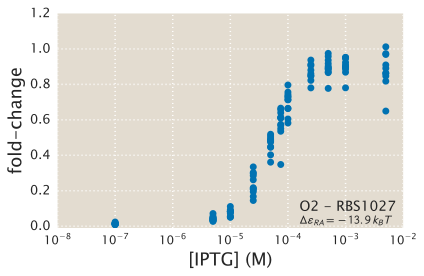

In [33]:
fig, ax = plt.subplots(1, 1)

ax.plot(rbs.IPTG_uM / 1E6,
         rbs.fold_change_A, 'o',
         alpha=0.7)
ax.set_xscale('log')
ax.set_xlabel('[IPTG] (M)')
ax.set_ylabel('fold-change')
ax.set_xlim([1E-8, 1E-2])
ax.set_ylim([-0.01, 1.2])
# Add operator and binding energy labels.
ax.text(0.7, 0.08, r'{0}'.format('O2 - RBS1027'), transform=ax.transAxes, 
        fontsize=14)
ax.text(0.7, 0.02,
        r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %-13.9,
        transform=ax.transAxes, fontsize=12)

plt.tight_layout()

Now let's define all the necessary stuff to run the MCMC. In order to minimize the dataframe parsing that the log-posterior has to do when performing the MCMC let's write a pre-processing function that will parse the data once such that the output can be feed to the log-posterior function.

In [34]:
def mcmc_pre_process(df):
    """
    Pre-process the tidy DataFrame to prepare it for the MCMC. This is done
    separately from the log-posterior calculation to speed up the process
    avoiding parsing the DataFrame every evaluation of the posterior.
    Parameteres
    -----------
    df : pandas DataFrame.
        A tidy pandas DataFrame as standardized in the project that contains
        at least the following columns:
        fold_change_A : the experimental fold-change from channel A in the
        flow cytometer.
    IPTG_uM : 1d-array
        Concentrations of the inducer in micromolar. 
    repressors : int
        The mean repressor copy number in copies per cell. 
    binding_energy : float
        The mean repressor binding energy

    Returns
    -------
    [rep_unique, eps_unique] : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where each parameter is
        located. The logic is the following:
        In the first three positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma, which is the error associated with the 
        Gaussian likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : binding_energy
    """
    # List the unique variables
    rep_unique = np.sort(df.repressors.unique())
    eps_unique = np.sort(df.binding_energy.unique())
    IPTG_unique = np.sort(df.IPTG_uM.unique())
    
    # determine the number of unique variables
    n_repressor = len(rep_unique)
    n_epsilon_r = len(eps_unique)
    n_IPTG = len(IPTG_unique)
    
    # Depending on the number of parameters determine the indexes of the
    # parameters to fit
    param_idx = np.cumsum([3, n_repressor, n_epsilon_r])
    
    # Sort the data frame such that the log-posterior function can
    # automatically compute the log probability with the right parameters
    # for each data point
    df_sort = df.sort(['repressors', 'binding_energy', 'IPTG_uM'])
    data = np.array(df_sort[['fold_change_A', 'IPTG_uM', 
                             'repressors', 'binding_energy']])
    return [rep_unique, eps_unique], param_idx, data

To initialize the walkeres we use the non-linear regression approach to find the most probable parameter values and then initialize the walkers within that region using `numpy`'s `multivariate_normal` sampler.

In [35]:
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(rbs, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

Lets pass our dataframe into the pre-process function.

In [36]:
unique_var, param_idx, data = mcmc_pre_process(rbs)

/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:65: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [37]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

Let's instantiate the sampler

In [38]:
# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
            args=(param_idx, unique_var, data, 4.5),\
            threads=6)

Perform the burn-in steps.

In [39]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Once we do the burn-in steps let's now run the real MCMC routine!

For convenience we will pickle the sampler such that we can load the MCMC results without having to re-run the code.

In [40]:
sample = False
if sample:
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/main_text_KaKi.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

Let's visualize the results!

ValueError: Contour levels must be increasing

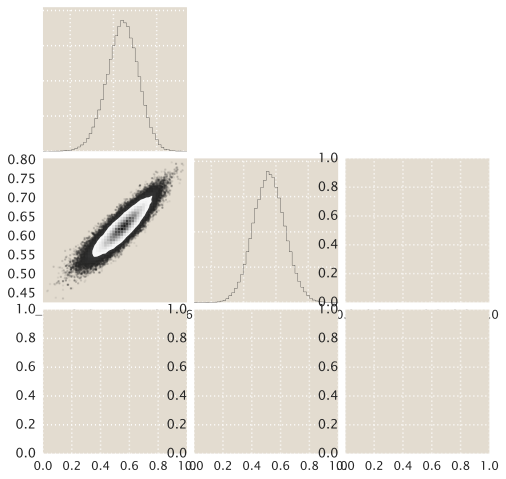

In [41]:
# Load the flat-chain
with open('../../data/mcmc/main_text_KaKi.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()


# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\tilde{k}_A$', r'$\tilde{k}_I$', r'$\sigma$'])

### Reporting the results.

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain.

In [18]:
# Load the flat-chain
with open('../../data/mcmc/main_text_KaKi.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['ka', 'ki', 'sigma']

# Generate a data frame out of the MCMC chains
mcmc_rbs = pd.DataFrame(gauss_flatchain, columns=index)
mcmc_rbs['Ka'] = np.exp(-mcmc_rbs['ka'])
mcmc_rbs['Ki'] = np.exp(-mcmc_rbs['ki'])

# rerbsine the index with the new entries
index = mcmc_rbs.columns
mcmc_rbs.head()

,ka,ki,sigma,Ka,Ki
0,-4.939512,0.629315,0.055774,139.702079,0.532957
1,-4.930021,0.634059,0.055659,138.382354,0.530434
2,-4.925847,0.634445,0.056416,137.805995,0.530230
3,-4.933978,0.648470,0.056010,138.931092,0.522845
4,-4.944385,0.648084,0.056254,140.384424,0.523047


In [19]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
ea, ei, sigma, Ka, Ki = mcmc_rbs.ix[max_idx, :]

# ea range
ea_hpd = mwc.hpd(mcmc_rbs.ix[:, 0], 0.95)
ei_hpd = mwc.hpd(mcmc_rbs.ix[:, 1], 0.95)
Ka_hpd = mwc.hpd(mcmc_rbs.ix[:, 3], 0.95)
Ki_hpd = mwc.hpd(mcmc_rbs.ix[:, 4], 0.95)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} -{1:0.2f} +{2:0.2f} µM
Ki = {3:.2f} -{4:0.3f} +{5:0.3f} µM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 139.58 -22.79 +28.09 µM
Ki = 0.53 -0.040 +0.043 µM



Let's see how these parameters predict the rest of the strains.

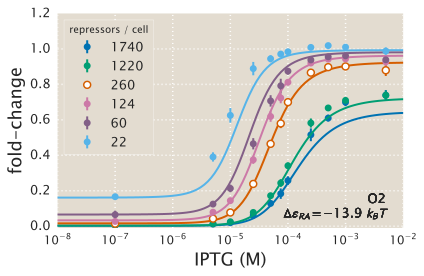

In [20]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 100)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O2']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize subplots
fig = plt.figure()
ax = plt.subplot(111)

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
         # plot the theory using the parameters from the fit.
        ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        if rbs=='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                     color=colors[j],
                    label=None,  linestyle='none')
            ax.plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, marker='o', markeredgewidth=1.5, 
                    markeredgecolor=colors[j],
                    markerfacecolor='w', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                    linestyle='none')
        elif rbs!='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j], linestyle='none')
                    # Label the plot with the operator name and the energy
        ax.text(0.95, 0.1, op + 
                '\n' + r'$\Delta\varepsilon_{RA} =$' +\
                '{:.1f}'.format(energies[op]) + r' $k_BT$',
                ha='right', va='center',
                transform=ax.transAxes, fontsize=13)

# Format the axis
ax.set_xscale('log')
ax.set_xlabel('IPTG (M)')
ax.set_ylabel('fold-change')
ax.set_ylim([-0.01, 1.2])
ax.set_xlim([1E-8, 1E-2])
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Make the labels be numeric
labels = [int(x) for x in labels]
# Sort both lists by this numeric label
labels, handles = (list(x) for x in zip(*sorted(zip(labels, handles), reverse=True)))
# Convert back the labels to strings
labels = [str(x) for x in labels]
# use this order for the legend
ax.legend(handles, labels, loc='upper left', title='repressors / cell')
plt.tight_layout()

# Plotting the credible region using the MCMC traces.

Now that we not only know the MAP value of the MWC parameters, but also the credible intervals for them we can properly reflect that uncertainty on our plots.

Drawing a proper credible region on the fold-change curve is not as straight forwared as taking both lower and upper boundaries of the HPD and plotting these values since, as shown in the MCMC trace plot the paraemeters are clearly correlated. But we can take advantage of the MCMC traces to compute the proper credible intevals.

Think about it in the following way: The MCMC walkers explore the parameter space in a way proportional to the probability of each of the parameters, so if we were to compute the fold change for each and every step this would be done proportionally to how probable each fold-change value is, taking into account all the possible complicated non-linear relationships between parameters.

It might be computationally more expensive, but this way guarantees that the credible regions are drawn according to the proper posterior probability of the parameters.

Let's define a function that takes the `emcee` `flatchains` and computes the confidence interval.

In [21]:
def mcmc_cred_region(IPTG, flatchain, R, epsilon_r,
                     mass_frac=.95, epsilon=4.5):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        MCMC traces for the two MWC parameters.
        flatchain[:,0] = ~ka flat-chain
        flatchain[:,1] = ~ki flat-chain
    R : float.
        Mean repressor copy number.
    epsilon_r : float.
        Repressor binding energy.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = mwc.fold_change_log(c, flatchain[:,0], flatchain[:, 1], epsilon,
                                R, epsilon_r)
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    
    return cred_region

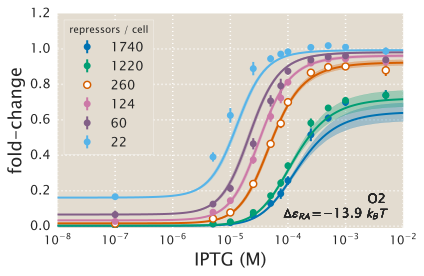

In [22]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 100)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O2']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize subplots
fig = plt.figure()
ax = plt.subplot(111)

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
         # plot the theory using the parameters from the fit.
        ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mcmc_cred_region(IPTG * 1E6, 
            gauss_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op])
        ax.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                        alpha=0.3, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        if rbs=='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                     color=colors[j],
                    label=None,  linestyle='none')
            ax.plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, marker='o', markeredgewidth=1.5, 
                    markeredgecolor=colors[j],
                    markerfacecolor='w', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                    linestyle='none')
        elif rbs!='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j], linestyle='none')
                    # Label the plot with the operator name and the energy
        ax.text(0.95, 0.1, op + 
                '\n' + r'$\Delta\varepsilon_{RA} =$' +\
                '{:.1f}'.format(energies[op]) + r' $k_BT$',
                ha='right', va='center',
                transform=ax.transAxes, fontsize=13)

# Format the axis
ax.set_xscale('log')
ax.set_xlabel('IPTG (M)')
ax.set_ylabel('fold-change')
ax.set_ylim([-0.01, 1.2])
ax.set_xlim([1E-8, 1E-2])
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Make the labels be numeric
labels = [int(x) for x in labels]
# Sort both lists by this numeric label
labels, handles = (list(x) for x in zip(*sorted(zip(labels, handles), reverse=True)))
# Convert back the labels to strings
labels = [str(x) for x in labels]
# use this order for the legend
ax.legend(handles, labels, loc='upper left', title='repressors / cell')
plt.tight_layout()

## Testing the prediction with other operators.

As a way to test how well the fit to a single strain can predict the rest of the operators, we will plot the predictions using this set of parameters for all of the data sets.

In [23]:
# Read the data
datadir = '../../data/'
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

Now we will plot using the predictions for the single fit strain.

O1
O2
O3


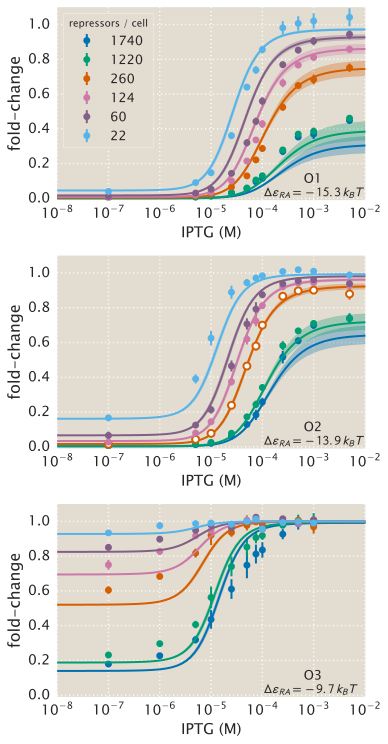

In [24]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3'] #, 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize the plot to set the size
fig,ax = plt.subplots(3, 1, figsize=(5.5, 10.5))

# Loop through operators
for i, op in enumerate(operators):
    print(op)
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mwc.mcmc_cred_region(IPTG * 1e6,
            gauss_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op])
        ax[i].fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                        alpha=0.3, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        # Distinguish between the fit data and the predictions
        if (op == 'O2') & (rbs == 'RBS1027'):
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err, linestyle='none', color=colors[j])
            ax[i].plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                       fc_mean, marker='o', linestyle='none',
                       markeredgewidth=2, markeredgecolor=colors[j],
                       markerfacecolor='w', 
                       label=df[df.rbs=='RBS1027'].repressors.unique()[0] * 2)
        else:
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                    fmt='o', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j])

    # Add operator and binding energy labels.
    ax[i].text(0.8, 0.09, r'{0}'.format(op), transform=ax[i].transAxes, 
            fontsize=13)
    ax[i].text(0.67, 0.02,
            r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
            transform=ax[i].transAxes, fontsize=13)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].tick_params(labelsize=14)
    ax[i].margins(0.02)
ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.tight_layout()

## Running the MCMC with all the data.

An interesting thing to try is to fit the dissociation constants using the data for all 3 operators O1, O2, and O3. We follow the same approach as before with our MCMC, but rather than look at data from one strain, we consider all the data available from our flow cytometry work.

In [25]:
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

# Pre-process the dataframe
unique_var, param_idx, data = mcmc_pre_process(df)

#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:65: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [26]:
# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
            args=(param_idx, unique_var, data, 4.5),\
            threads=6)

In [27]:
sample = False
if sample:
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/alldata_KaKi.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)

In [28]:
# read the flat-chain
with open('../../data/mcmc/alldata_KaKi.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    gauss_pool_flatlnprobability = unpickler.load()

# plot the corner plot
fig = corner.corner(gauss_pool_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\tilde{k}_A$', r'$\tilde{k}_I$', r'$\sigma$'])

FileNotFoundError: [Errno 2] No such file or directory: '../../data/mcmc/alldata_KaKi.pkl'

In [ ]:
# Load the flat-chain
with open('../../data/mcmc/alldata_KaKi.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['ka', 'ki', 'sigma']

# Generate a data frame out of the MCMC chains
mcmc_rbs = pd.DataFrame(gauss_flatchain, columns=index)
mcmc_rbs['Ka'] = np.exp(-mcmc_rbs['ka'])
mcmc_rbs['Ki'] = np.exp(-mcmc_rbs['ki'])

# rerbsine the index with the new entries
index = mcmc_rbs.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
ea, ei, sigma, Ka, Ki = mcmc_rbs.ix[max_idx, :]

# ea range
ea_hpd = mwc.hpd(mcmc_rbs.ix[:, 0], 0.95)
ei_hpd = mwc.hpd(mcmc_rbs.ix[:, 1], 0.95)
Ka_hpd = mwc.hpd(mcmc_rbs.ix[:, 3], 0.95)
Ki_hpd = mwc.hpd(mcmc_rbs.ix[:, 4], 0.95)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} -{1:0.2f} +{2:0.2f} µM
Ki = {3:.2f} -{4:0.3f} +{5:0.3f} µM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))

In [ ]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3'] #, 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize the plot to set the size
fig,ax = plt.subplots(3, 1, figsize=(5.5, 10.5))

# Loop through operators
for i, op in enumerate(operators):
    print(op)
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mwc.mcmc_cred_region(IPTG * 1e6,
            gauss_pool_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op])
        ax[i].fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                        alpha=0.3, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        # Distinguish between the fit data and the predictions
        if (op == 'O2') & (rbs == 'RBS1027'):
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err, linestyle='none', color=colors[j])
            ax[i].plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                       fc_mean, marker='o', linestyle='none',
                       markeredgewidth=2, markeredgecolor=colors[j],
                       markerfacecolor='w', 
                       label=df[df.rbs=='RBS1027'].repressors.unique()[0] * 2)
        else:
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                    fmt='o', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j])

    # Add operator and binding energy labels.
    ax[i].text(0.8, 0.09, r'{0}'.format(op), transform=ax[i].transAxes, 
            fontsize=13)
    ax[i].text(0.67, 0.02,
            r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
            transform=ax[i].transAxes, fontsize=13)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].tick_params(labelsize=14)
    ax[i].margins(0.02)
ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.tight_layout()